In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd

2021-12-21 12:56:55.362642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-21 12:56:55.362688: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'non_gene_2':'./data/gene/non_gene_2.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'bam234':'./data/051_234.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['4','2','3']:
            TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema_1'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
# with open(dic['ATAC_hema_2'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1'] and ll[2] == '0':
#             TSS_HK.append(TSS(ll[0],int(ll[1])))        
# tss_pre = []
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['2'] and ll[2] == '0':
#             tss_pre.append(TSS(ll[0],int(ll[1])))

TSS_NonGene = []
with open(dic['non_gene_2'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))



bamfile = ps.AlignmentFile(dic['bam234'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000


In [5]:
#lstm
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)


In [6]:
#lstm
feature_matrix_pre = []
for j, tss in enumerate(tss_pre):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix_pre.append(feature_win)
feature_matrix_pre = np.array(feature_matrix_pre)

lstm_x_pre = []
for mat in feature_matrix_pre:
    lstm_x_pre.append(mat)
lstm_x_pre = np.array(lstm_x_pre)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import KFold

In [8]:

def creat_model():
    model = keras.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True),input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None))
    # model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None))
    # model.add(keras.layers.Dropout(0.2))
    # model.add(keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='4'))
    model.add(keras.layers.Dense(2, activation='softmax', kernel_regularizer=None, bias_regularizer=None))
    # adam = keras.optimizers.Adam(lr=1e-4)
    # model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:

n_split = 5
x = lstm_x
y = keras.utils.to_categorical(labels)
id = []
ypred = np.empty(shape=[0,2])
for train_index, test_index in KFold(n_split).split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = creat_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    adam = keras.optimizers.Adam(lr=1e-4)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=100, batch_size=128,verbose=0, validation_split=0.1, callbacks=[EarlyStopping(patience=10)], shuffle=True)
    pp = model.predict(x_test)
    id += list(test_index)
    ypred = np.concatenate((ypred, pp))
x_train = x[id]
y_train = labels[id]

2021-12-21 13:25:43.827957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-21 13:25:43.827990: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-21 13:25:43.828009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jiay-virtual-machine): /proc/driver/nvidia/version does not exist
2021-12-21 13:25:43.828235: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The

In [10]:
t = [[],[]]
for i in range(len(y_train)):
    t[y_train[i]].append(i)
t0 = np.mean([ypred[i][0]for i in t[0]])
t1 = np.mean([ypred[i][1]for i in t[1]])
print(t0,t1)
yconf = []
ymax = []
for i in range(len(ypred)):
    if ypred[i][0] > ypred[i][1] and ypred[i][0] >= t0:
        yconf.append(0)
        ymax.append(0)
    elif ypred[i][1] > ypred[i][0] and ypred[i][1] >= t1:
        yconf.append(1)
        ymax.append(1)
    else:
        yconf.append(-1)
        if ypred[i][1] > ypred[i][0]:
            ymax.append(1)
        else:
            ymax.append(0)
matrix_c = np.zeros((2,2),dtype=int)
for i in range(len(y_train)):
    if yconf[i] == -1:
        continue
    matrix_c[y_train[i]][yconf[i]] += 1
matrix_qc = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_qc = matrix_c / np.sum(matrix_c)

wqc0 = (matrix_qc[0][0] + matrix_qc[0][1])/matrix_qc[0][0]
wqc1 = (matrix_qc[1][0] + matrix_qc[1][1])/matrix_qc[1][1]

matrix_c1 = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_c1[i][j] = matrix_c[i][j] * len([k for k in y_train if k == i]) / np.sum(matrix_c[i])
print(matrix_c)
print(matrix_c1)
matrix_q = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_q = matrix_c1 / np.sum(matrix_c1)
print(matrix_q)
print(len([i for i in yconf if i == -1]))

wq0 = (matrix_q[0][0] + matrix_q[0][1])/matrix_q[0][0]
wq1 = (matrix_q[1][0] + matrix_q[1][1])/matrix_q[1][1]
print("wqc:",wqc0,wqc1)
print("wq:",wq0,wq1)

0.5013668353378495 0.7569257628747604
[[2046  667]
 [1553 3665]]
[[2593.51050498  845.48949502]
 [1812.82541204 4278.17458796]]
[[0.27214171 0.08871873]
 [0.19022302 0.44891654]]
1599
wqc: 1.326001955034213 1.423738062755798
wq: 1.326001955034213 1.423738062755798


In [12]:
'''base line'''
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, keras.utils.to_categorical(y_train), epochs=100, batch_size=128, verbose=0)#validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./'+str(noise_fraction*100)+'/raw.h5', save_best_only=True)], shuffle=True, verbose=0)
ppp = model.predict(lstm_x_pre)
countp = 0
for p in ppp:
    if p[0] <= p[1]:
        countp += 1
print(countp/len(ppp))

/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


0.6132505175983437


In [20]:
def focal_loss_q(y_true, y_pred):
   gamma = 0
   alpha = 0.5
   w1 = wq1
   w0 = wq0
   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
   return -K.sum(w1 * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum(w0 * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [24]:
'''method 1'''
reserved_id = []
for i, tt in enumerate(ypred):
    if ymax[i] == y_train[i]:
        reserved_id.append(i)
reserved_id = np.array(reserved_id)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = x_train[reserved_id]
reserved_y = y_train[reserved_id]
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=100, batch_size=128,verbose=0)# validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./'+str(noise_fraction*100)+'/cl_1.h5', save_best_only=True)], shuffle=True, verbose=0)
ppp = model.predict(lstm_x_pre)
countp = 0
for p in ppp:
    if p[0] <= p[1]:
        countp += 1
print(countp/len(ppp))
print(len(reserved_x))

0.6627329192546584
6585


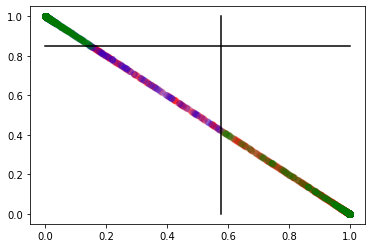

0.7134575569358178


In [39]:
'''cl method 2'''
exclude = []
reserved_0 = []
reserved_1 = []
for i, tt in enumerate(yconf):
    if tt == -1:
        if y_train[i] == 0:
            reserved_0.append(i)
        else:
            reserved_1.append(i)
        continue
    if y_train[i] != yconf[i]:
        if y_train[i] == 0:
            exclude.append(i)
            continue
        else:
            exclude.append(i)
            continue
    if y_train[i] == 0:
        reserved_0.append(i)
    else:
        reserved_1.append(i)
ex = np.array([ypred[i] for i in exclude])
re_0 = np.array([ypred[i] for i in reserved_0])
re_1 = np.array([ypred[i] for i in reserved_1])

plt.scatter(re_0[:,0],re_0[:,1],color='r',alpha=0.1)
plt.scatter(re_1[:,0],re_1[:,1],color='b',alpha=0.1)

plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.1)
plt.plot([t0,t0],[0,1],color='black')
plt.plot([0,1],[t1,t1],color='black')
plt.show()
reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = x_train[reserved_id]
reserved_y = y_train[reserved_id]
# train_x = reserved_x[:int(len(reserved_x)*0.8)]
# train_y = keras.utils.to_categorical(reserved_y[:int(len(reserved_y)*0.8)])
# test_x = reserved_x[int(len(reserved_x)*0.8):]
# test_y = keras.utils.to_categorical(reserved_y[int(len(reserved_y)*0.8):])
train_x = reserved_x
train_y = keras.utils.to_categorical(reserved_y)
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_x, train_y, epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./0_cl.h5', save_best_only=True)], shuffle=True, verbose=2,)
# model.evaluate(test_x,test_y)
# print(len(exclude),len(reserved_1),len(reserved_0))
# model = creat_model()
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# model.fit(lstm_x, keras.utils.to_categorical(labels), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./0_nl.h5', save_best_only=True)], shuffle=True, verbose=2,)
ppp = model.predict(lstm_x_pre)
countp = 0
for p in ppp:
    if p[0] <= p[1]:
        countp += 1
print(countp/len(ppp))

In [40]:
'''method 3'''

import cleanlab
pbc = cleanlab.pruning.get_noise_indices(y_train, np.array(ypred), prune_method='prune_by_class',n_jobs=1)
reserved_id = []
for i in range(len(pbc)):
    if pbc[i] == False:
        reserved_id.append(i)
model = creat_model()
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=200, batch_size=128, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./'+str(noise_fraction*100)+'/cl_3.h5', save_best_only=True)], shuffle=True, verbose=0)
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./'+str(noise_fraction*100)+'/cl_3.h5', save_best_only=True)], shuffle=True, verbose=0)
ppp = model.predict(lstm_x_pre)
countp = 0
for p in ppp:
    if p[0] <= p[1]:
        countp += 1
print(countp/len(ppp))

/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


0.6542443064182195


In [41]:
'''method 4'''
import cleanlab
pbnr = cleanlab.pruning.get_noise_indices(y_train, ypred, prune_method='prune_by_noise_rate', n_jobs=1)
reserved_id = []
for i in range(len(pbnr)):
    if pbnr[i] == False:
        reserved_id.append(i)
reserved_id = np.array(reserved_id)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = x_train[reserved_id]
reserved_y = y_train[reserved_id]
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./'+str(noise_fraction*100)+'/cl_4.h5', save_best_only=True)], shuffle=True, verbose=0)
ppp = model.predict(lstm_x_pre)
countp = 0
for p in ppp:
    if p[0] <= p[1]:
        countp += 1
print(countp/len(ppp))

/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


0.643271221532091


In [42]:
'''method 5'''
import cleanlab
pbnr = cleanlab.pruning.get_noise_indices(y_train, ypred, prune_method='both', n_jobs=1)
reserved_id = []
for i in range(len(pbnr)):
    if pbnr[i] == False:
        reserved_id.append(i)
reserved_id = np.array(reserved_id)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = x_train[reserved_id]
reserved_y = y_train[reserved_id]

model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./'+str(noise_fraction*100)+'/cl_5.h5', save_best_only=True)], shuffle=True, verbose=0)
ppp = model.predict(lstm_x_pre)
countp = 0
for p in ppp:
    if p[0] <= p[1]:
        countp += 1
print(countp/len(ppp))

/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


0.6322981366459627


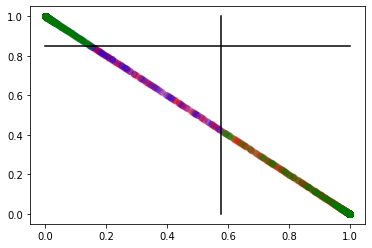

411 1944 5054


In [43]:
'''improved method 2'''

exclude = []
reserved_0 = []
reserved_1 = []
res = []
rr_0 = []
rr_1 = []
for i, tt in enumerate(yconf):
    if tt == -1:
        res.append(i)
        if y_train[i] == 0:
            rr_0.append(i)
        else:
            rr_1.append(i)
        continue
    if y_train[i] != yconf[i]:
        if y_train[i] == 0:
            exclude.append(i)
            continue
        else:
            exclude.append(i)
            continue
    if y_train[i] == 0:
        reserved_0.append(i)
    else:
        reserved_1.append(i)

ex = np.array([ypred[i] for i in exclude])
re_0 = np.array([ypred[i] for i in reserved_0+rr_0])
re_1 = np.array([ypred[i] for i in reserved_1+rr_1])
plt.scatter(re_0[:,0],re_0[:,1],color='r',alpha=0.1)
plt.scatter(re_1[:,0],re_1[:,1],color='b',alpha=0.1)
plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.1)
plt.plot([t0,t0],[0,1],color='black')
plt.plot([0,1],[t1,t1],color='black')
plt.show()

reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = x_train[reserved_id]
reserved_y = y_train[reserved_id]
print(len(res),len(reserved_0),len(reserved_1))
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./0_tr.h5', save_best_only=True)], shuffle=True, verbose=2,)


In [44]:
ypr = model.predict(x_train[res])
ylabed = y_train[res]
t = [[],[]]
for i in range(len(ylabed)):
    t[ylabed[i]].append(i)
t0 = np.mean([ypr[i][0]for i in t[0]])
t1 = np.mean([ypr[i][1]for i in t[1]])
print(t0,t1)
yconf = []
for i in range(len(ypr)):
    if ypr[i][0] > ypr[i][1] and ypr[i][0] >= t0:
        yconf.append(0)
    elif ypr[i][1] > ypr[i][0] and ypr[i][1] >= t1:
        yconf.append(1)
    else:
        yconf.append(-1)
matrix_c = np.zeros((2,2),dtype=int)
for i in range(len(ylabed)):
    if yconf[i] == -1:
        continue
    matrix_c[ylabed[i]][yconf[i]] += 1

matrix_c1 = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_c1[i][j] = matrix_c[i][j] * len([k for k in ylabed if k == i]) / np.sum(matrix_c[i])
print(matrix_c)
print(matrix_c1)
matrix_q = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_q = matrix_c1 / np.sum(matrix_c1)
print(matrix_q)
print(len([i for i in yconf if i == -1]))
exclude = []
reserved_0 = []
reserved_1 = []
res = []
rr_0 = []
rr_1 = []
for i, tt in enumerate(yconf):
    if tt == -1:
        res.append(i)
        if ylabed[i] == 0:
            rr_0.append(i)
        else:
            rr_1.append(i)
        continue
    if ylabed[i] != yconf[i]:
        if ylabed[i] == 0:
            exclude.append(i)
            continue
        else:
            exclude.append(i)
            continue
    if ylabed[i] == 0:
        reserved_0.append(i)
    else:
        reserved_1.append(i)

ex = np.array([ypr[i] for i in exclude])
re_0 = np.array([ypr[i] for i in reserved_0+rr_0])
re_1 = np.array([ypr[i] for i in reserved_1+rr_1])
plt.scatter(re_0[:,0],re_0[:,1],color='r',alpha=0.1)
plt.scatter(re_1[:,0],re_1[:,1],color='b',alpha=0.1)
plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.1)
plt.plot([t0,t0],[0,1],color='black')
plt.plot([0,1],[t1,t1],color='black')
plt.show()

reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = x_train[reserved_id]
reserved_y = y_train[reserved_id]
print("res=",len(res),"res_0=",len(reserved_0),"res_1=",len(reserved_1))
# model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./0_tr.h5', save_best_only=True)], shuffle=True, verbose=2,)


0.65136474 0.5176712
[[179  99]
 [ 59  61]]
[[183.50719424 101.49280576]
 [ 61.95        64.05      ]]
[[0.44648952 0.24694113]
 [0.15072993 0.15583942]]
13


res= 13 res_0= 179 res_1= 61


0.46037492 0.8463154
[[11  6]
 [ 3 27]]
[[13.58823529  7.41176471]
 [ 3.7        33.3       ]]
[[0.23427992 0.12778905]
 [0.0637931  0.57413793]]
11


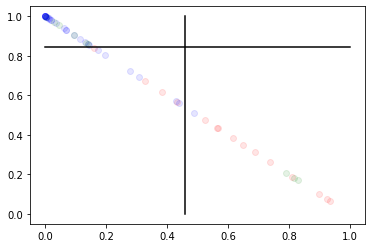

11 11 27
Epoch 1/200
1/1 - 0s - loss: 0.4239 - accuracy: 0.7941 - val_loss: 0.4781 - val_accuracy: 0.5000
Epoch 2/200
1/1 - 0s - loss: 0.4234 - accuracy: 0.7647 - val_loss: 0.4931 - val_accuracy: 0.5000
Epoch 3/200
1/1 - 0s - loss: 0.4206 - accuracy: 0.7353 - val_loss: 0.5107 - val_accuracy: 0.5000
Epoch 4/200
1/1 - 0s - loss: 0.4042 - accuracy: 0.7059 - val_loss: 0.5246 - val_accuracy: 0.5000
Epoch 5/200
1/1 - 0s - loss: 0.3742 - accuracy: 0.7647 - val_loss: 0.5216 - val_accuracy: 0.5000
Epoch 6/200
1/1 - 0s - loss: 0.3042 - accuracy: 0.8824 - val_loss: 0.4972 - val_accuracy: 0.5000
Epoch 7/200
1/1 - 0s - loss: 0.3081 - accuracy: 0.8824 - val_loss: 0.4695 - val_accuracy: 0.5000
Epoch 8/200
1/1 - 0s - loss: 0.2595 - accuracy: 0.9412 - val_loss: 0.4570 - val_accuracy: 0.5000
Epoch 9/200
1/1 - 0s - loss: 0.2762 - accuracy: 0.9118 - val_loss: 0.4745 - val_accuracy: 0.5000
Epoch 10/200
1/1 - 0s - loss: 0.2443 - accuracy: 0.9412 - val_loss: 0.5128 - val_accuracy: 0.5000
Epoch 11/200
1/1 - 0

In [55]:
ypr = model.predict(lstm_x[res])
ylabed = labels[res]
t = [[],[]]
for i in range(len(ylabed)):
    t[ylabed[i]].append(i)
t0 = np.mean([ypr[i][0]for i in t[0]])
t1 = np.mean([ypr[i][1]for i in t[1]])
print(t0,t1)
yconf = []
for i in range(len(ypr)):
    if ypr[i][0] > ypr[i][1] and ypr[i][0] >= t0:
        yconf.append(0)
    elif ypr[i][1] > ypr[i][0] and ypr[i][1] >= t1:
        yconf.append(1)
    else:
        yconf.append(-1)
matrix_c = np.zeros((2,2),dtype=int)
for i in range(len(ylabed)):
    if yconf[i] == -1:
        continue
    matrix_c[ylabed[i]][yconf[i]] += 1

matrix_c1 = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_c1[i][j] = matrix_c[i][j] * len([k for k in ylabed if k == i]) / np.sum(matrix_c[i])
print(matrix_c)
print(matrix_c1)
matrix_q = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_q = matrix_c1 / np.sum(matrix_c1)
print(matrix_q)
print(len([i for i in yconf if i == -1]))
exclude = []
reserved_0 = []
reserved_1 = []
res = []
rr_0 = []
rr_1 = []
for i, tt in enumerate(yconf):
    if tt == -1:
        res.append(i)
        if ylabed[i] == 0:
            rr_0.append(i)
        else:
            rr_1.append(i)
        continue
    if ylabed[i] != yconf[i]:
        if ylabed[i] == 0:
            exclude.append(i)
            continue
        else:
            exclude.append(i)
            continue
    if ylabed[i] == 0:
        reserved_0.append(i)
    else:
        reserved_1.append(i)

ex = np.array([ypr[i] for i in exclude])
re_0 = np.array([ypr[i] for i in reserved_0+rr_0])
re_1 = np.array([ypr[i] for i in reserved_1+rr_1])
plt.scatter(re_0[:,0],re_0[:,1],color='r',alpha=0.1)
plt.scatter(re_1[:,0],re_1[:,1],color='b',alpha=0.1)
plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.1)
plt.plot([t0,t0],[0,1],color='black')
plt.plot([0,1],[t1,t1],color='black')
plt.show()

reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = lstm_x[reserved_id]
reserved_y = labels[reserved_id]
print(len(res),len(reserved_0),len(reserved_1))
# model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./0_tr.h5', save_best_only=True)], shuffle=True, verbose=2,)


In [45]:
ypr = model.predict(lstm_x[res])
ylabed = labels[res]
t = [[],[]]
for i in range(len(ylabed)):
    t[ylabed[i]].append(i)
t0 = np.mean([ypr[i][0]for i in t[0]])
t1 = np.mean([ypr[i][1]for i in t[1]])
print(t0,t1)
yconf = []
for i in range(len(ypr)):
    if ypr[i][0] > ypr[i][1] and ypr[i][0] >= t0:
        yconf.append(0)
    elif ypr[i][1] > ypr[i][0] and ypr[i][1] >= t1:
        yconf.append(1)
    else:
        yconf.append(-1)
matrix_c = np.zeros((2,2),dtype=int)
for i in range(len(ylabed)):
    if yconf[i] == -1:
        continue
    matrix_c[ylabed[i]][yconf[i]] += 1

matrix_c1 = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_c1[i][j] = matrix_c[i][j] * len([k for k in ylabed if k == i]) / np.sum(matrix_c[i])
print(matrix_c)
print(matrix_c1)
matrix_q = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_q = matrix_c1 / np.sum(matrix_c1)
print(matrix_q)
print(len([i for i in yconf if i == -1]))
exclude = []
reserved_0 = []
reserved_1 = []
res = []
rr_0 = []
rr_1 = []
for i, tt in enumerate(yconf):
    if tt == -1:
        res.append(i)
        if ylabed[i] == 0:
            rr_0.append(i)
        else:
            rr_1.append(i)
        continue
    if ylabed[i] != yconf[i]:
        if ylabed[i] == 0:
            exclude.append(i)
            continue
        else:
            exclude.append(i)
            continue
    if ylabed[i] == 0:
        reserved_0.append(i)
    else:
        reserved_1.append(i)

ex = np.array([ypr[i] for i in exclude])
re_0 = np.array([ypr[i] for i in reserved_0+rr_0])
re_1 = np.array([ypr[i] for i in reserved_1+rr_1])
plt.scatter(re_0[:,0],re_0[:,1],color='r',alpha=0.1)
plt.scatter(re_1[:,0],re_1[:,1],color='b',alpha=0.1)
plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.1)
plt.plot([t0,t0],[0,1],color='black')
plt.plot([0,1],[t1,t1],color='black')
plt.show()

reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = lstm_x[reserved_id]
reserved_y = labels[reserved_id]
print(len(res),len(reserved_0),len(reserved_1))
# model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./0_tr.h5', save_best_only=True)], shuffle=True, verbose=2,)


0.999996 0.9000214
[[1 0]
 [0 9]]
[[ 3.  0.]
 [ 0. 10.]]
[[0.23076923 0.        ]
 [0.         0.76923077]]
3


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed